# testing out YTTiledArbitraryGrid

dev yt branch at https://github.com/chrishavlin/yt/tree/tiled_arbitrary_grid

WARNING: the nested grids can cache field data... initial implementaiton avoids this but doesnt account for field aliases. e.g., `('enzo','Density')` will **not** be cached but `

In [19]:
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid
import matplotlib.pyplot as plt 
import numpy as np


ds = yt.load_sample("DeeplyNestedZoom")
# INTERESTING: NEED TO BUILD INDEX BEFORE DASK CALL OR YOU GET ERROR ON DASK COMPUTE
ds.index 
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (2048,2048,2048), # global dimension
                     32, # nchunks = nprocs
                     ds=ds)

print("build delayed array")
da = tag.to_dask(('enzo','Density'), chunks=(64,64,64)) # chunks=chunksize!
da

yt : [INFO     ] 2024-06-07 14:10:22,327 Sample dataset found in '/Users/chavlin/data/yt_data/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-06-07 14:10:22,373 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-06-07 14:10:22,373 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-07 14:10:22,373 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-07 14:10:22,374 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-07 14:10:22,374 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-07 14:10:22,374 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-06-07 14:10:22,375 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-06-07 14:10:22,375 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-06-07 14:10:22,375 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-06-07 14:10:22,375 Parameters: hubb

build delayed array


dask.array<setitem, shape=(2048, 2048, 2048), dtype=float64, chunksize=(64, 64, 64), chunktype=numpy.ndarray>

**yikes, gotta watch the chunksizes.** even just building the delayed array can be very slow

In [20]:
%%time
da = tag.to_dask(('enzo','Density'), chunks=(64,64,64))
da

CPU times: user 12.9 s, sys: 188 ms, total: 13.1 s
Wall time: 13.1 s


dask.array<setitem, shape=(2048, 2048, 2048), dtype=float64, chunksize=(64, 64, 64), chunktype=numpy.ndarray>

In [21]:
%%time
da = tag.to_dask(('enzo','Density'), chunks=(256,256,256))
da

CPU times: user 81.1 ms, sys: 2.47 ms, total: 83.6 ms
Wall time: 83 ms


dask.array<setitem, shape=(2048, 2048, 2048), dtype=float64, chunksize=(256, 256, 256), chunktype=numpy.ndarray>

CPU times: user 8.73 s, sys: 24.9 s, total: 33.6 s
Wall time: 7.66 s


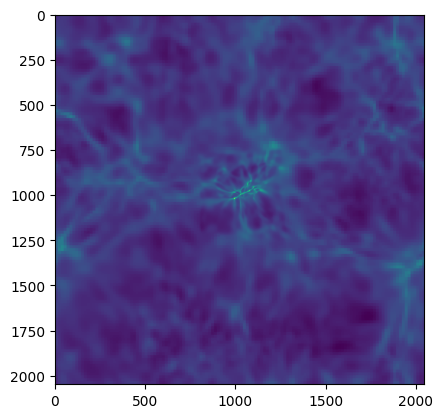

In [22]:
%%time
xr_da = tag.to_xarray(('enzo','Density'),chunks=(256,256,256))
plt.imshow(np.log10(xr_da[:,:,1024].compute()))

In [23]:
%%time
subset = xr_da[100:200,100:200,100:200].compute()

CPU times: user 521 ms, sys: 299 ms, total: 821 ms
Wall time: 827 ms


In [24]:
subset.shape

(100, 100, 100)

## ADDITIONAL TESTING BELOW HERE IN NO PARTICULAR ORDER

In [1]:
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid

In [2]:
ds = yt.load_sample("IsolatedGalaxy")

yt : [INFO     ] 2024-06-07 13:48:13,295 Sample dataset found in '/Users/chavlin/data/yt_data/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2024-06-07 13:48:13,391 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2024-06-07 13:48:13,391 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-06-07 13:48:13,391 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-07 13:48:13,392 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-07 13:48:13,392 Parameters: cosmological_simulation   = 0


In [3]:
YTTiledArbitraryGrid?

Init signature:
YTTiledArbitraryGrid(
    left_edge,
    right_edge,
    dims: tuple[int, int, int],
    nchunks: int,
    ds=None,
    field_parameters=None,
    parallel_method: str | None = None,
    data_source=None,
    cache: bool = False,
)
Docstring:      <no docstring>
File:           ~/src/yt_/yt_dev/yt/yt/data_objects/construction_data_containers.py
Type:           type
Subclasses:     

In [4]:
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (500,500,500),
                     10,
                     ds=ds)

# Fill an in-memory np array for testing...

In [5]:
%%time
dens = tag.to_numpy(("enzo", "Density"))

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 31221.32it/s]
yt : [INFO     ] 2024-06-07 13:48:13,440 Gathering a field list (this may take a moment.)


CPU times: user 1.02 s, sys: 197 ms, total: 1.21 s
Wall time: 1.22 s


In [6]:
dens.shape

(500, 500, 500)

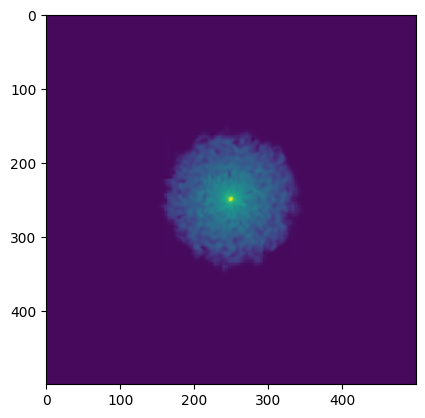

In [7]:
import matplotlib.pyplot as plt 
import numpy as np
plt.imshow(np.log10(dens[:,:,250]))

# how bout a dask array. 


In [8]:
%%time
dens = tag.to_dask(('enzo','Density'), chunks=(50,50,50))

CPU times: user 668 ms, sys: 3.47 s, total: 4.14 s
Wall time: 365 ms


In [12]:
dens

dask.array<setitem, shape=(500, 500, 500), dtype=float64, chunksize=(50, 50, 50), chunktype=numpy.ndarray>

In [10]:
%%time
vals = dens.compute()

CPU times: user 1.16 s, sys: 410 ms, total: 1.57 s
Wall time: 734 ms


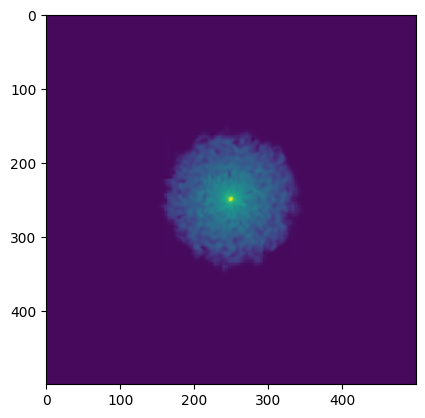

In [11]:
plt.imshow(np.log10(vals[:,:,250]))

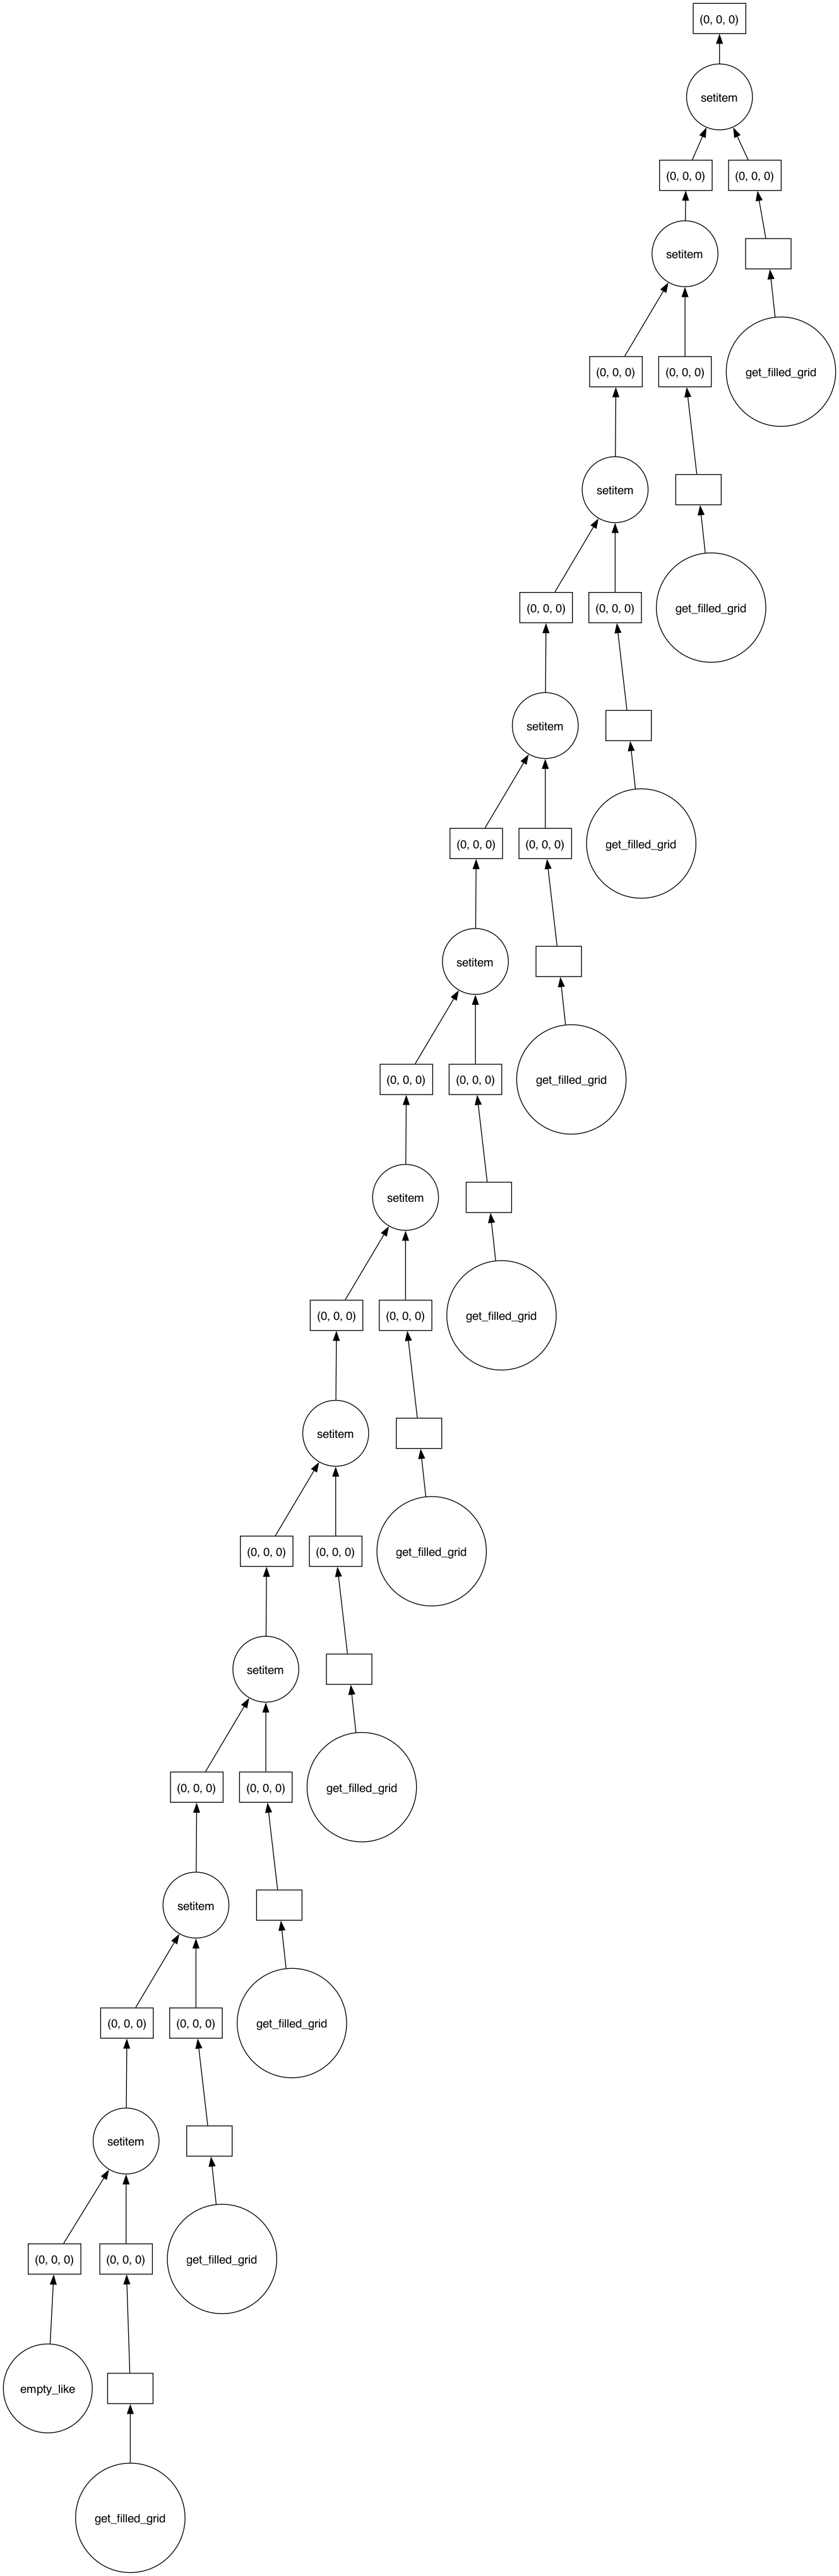

In [18]:
tag.to_dask(('enzo','Density'), chunks=(500, 500, 500)).visualize()

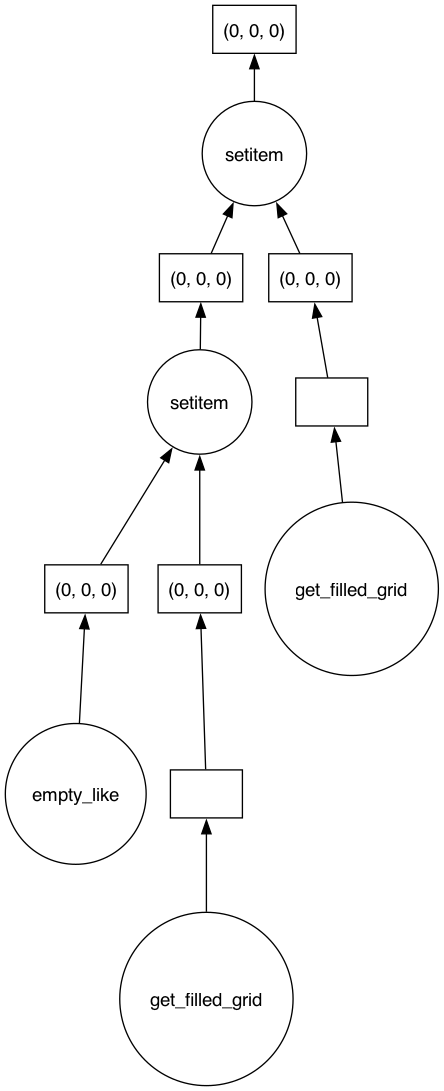

In [26]:
tag_2_grids = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (500,500,500),
                     2,
                     ds=ds)
tag_2_grids.to_dask(('enzo','Density'), chunks=(500, 500, 500)).visualize()

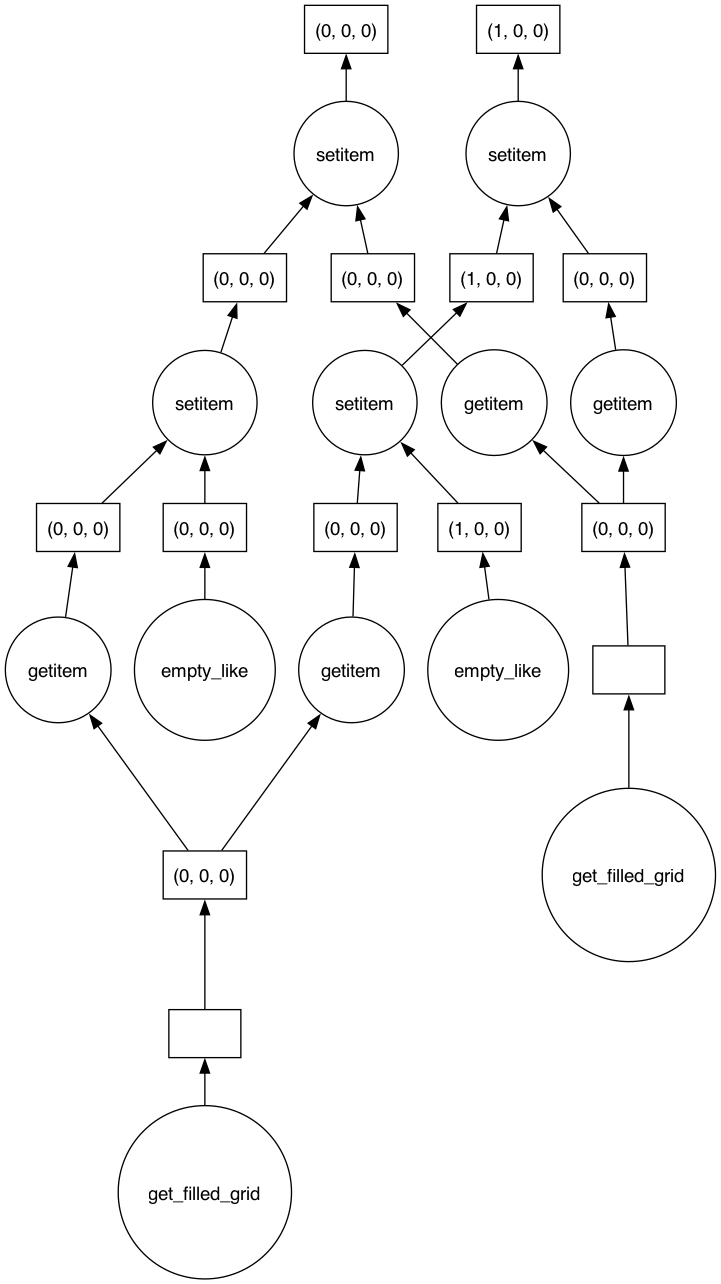

In [27]:
tag_2_grids = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (500,500,500),
                     2,
                     ds=ds)
tag_2_grids.to_dask(('enzo','Density'), chunks=(250, 500, 500)).visualize()

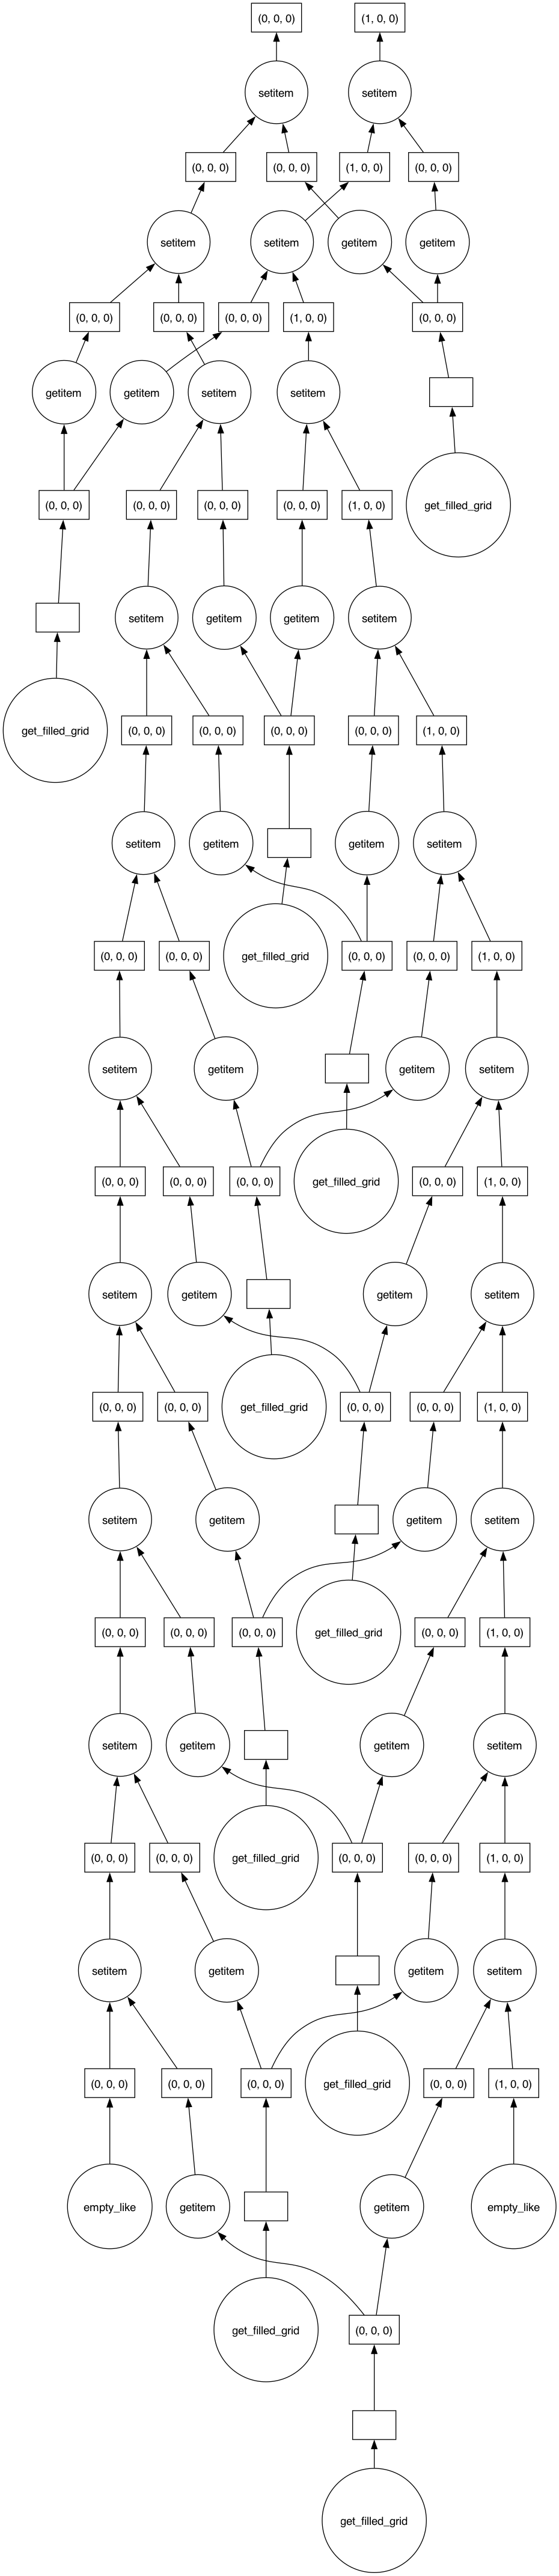

In [28]:
tag.to_dask(('enzo','Density'), chunks=(250, 500, 500)).visualize()

# and xarray dataaray (backed by dask)

In [20]:
%%time
xr_da = tag.to_xarray(('enzo','Density'), chunks=(50,50,50))

CPU times: user 169 ms, sys: 18.7 ms, total: 187 ms
Wall time: 185 ms


In [21]:
xr_ds = xr_da.to_dataset(promote_attrs=True)

In [22]:
xr_ds

<xarray.Dataset>
Dimensions:       (x: 500, y: 500, z: 500)
Coordinates:
  * x             (x) float64 0.001 0.003 0.005 0.007 ... 0.995 0.997 0.999
  * y             (y) float64 0.001 0.003 0.005 0.007 ... 0.995 0.997 0.999
  * z             (z) float64 0.001 0.003 0.005 0.007 ... 0.995 0.997 0.999
Data variables:
    enzo_Density  (x, y, z) float64 dask.array<chunksize=(50, 50, 50), meta=np.ndarray>
Attributes:
    ngrids:     10
    fieldname:  ('enzo', 'Density')

In [15]:
xr_ds.enzo_Density

<xarray.DataArray 'enzo_Density' (x: 500, y: 500, z: 500)>
dask.array<setitem, shape=(500, 500, 500), dtype=float64, chunksize=(50, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.001 0.003 0.005 0.007 ... 0.993 0.995 0.997 0.999
  * y        (y) float64 0.001 0.003 0.005 0.007 ... 0.993 0.995 0.997 0.999
  * z        (z) float64 0.001 0.003 0.005 0.007 ... 0.993 0.995 0.997 0.999
Attributes:
    ngrids:     10
    fieldname:  ('enzo', 'Density')

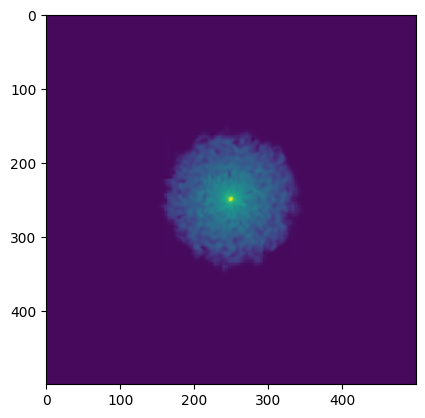

In [16]:
plt.imshow(np.log10(xr_ds.enzo_Density[:,:,250].compute()))

# ok, how bout a bigger array

In [22]:
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid
import matplotlib.pyplot as plt 
import numpy as np

ds = yt.load_sample("IsolatedGalaxy")
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (1000,1000,1000),
                     32,
                     ds=ds)

yt : [INFO     ] 2024-06-07 13:56:50,058 Sample dataset found in '/Users/chavlin/data/yt_data/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2024-06-07 13:56:50,102 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2024-06-07 13:56:50,102 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-06-07 13:56:50,103 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-07 13:56:50,103 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-07 13:56:50,103 Parameters: cosmological_simulation   = 0


In [23]:
ds.index # INTERESTING: NEED TO BUILD INDEX BEFORE DASK CALL OR YOU GET ERROR

Parsing Hierarchy : 100%|███████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 9725.17it/s]
yt : [INFO     ] 2024-06-07 13:56:51,316 Gathering a field list (this may take a moment.)


CPU times: user 1.4 s, sys: 769 ms, total: 2.17 s
Wall time: 651 ms


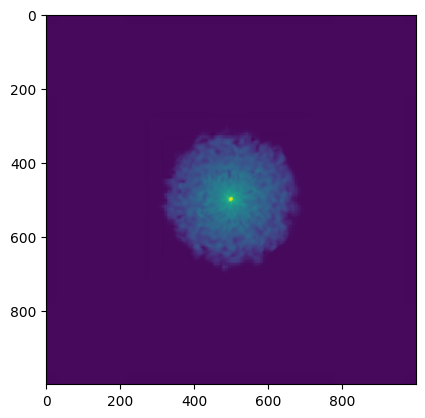

In [24]:
%%time
da = tag.to_dask(('enzo','Density'), chunks=(100,100,100))
plt.imshow(np.log10(da[:,:,500].compute()))

scaling seems broken though... bigger arrays fail for some reason. even just buildnig the graph is sloooooow